<a href="https://colab.research.google.com/github/sorayutmild/ENE461_sorayut/blob/main/ENE461_homework2_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Automatic Thresholding\
Description
Write a program to binarize images with automatic thresholding.


1) Maximum normal line method,


2) Average intensities method.



## นายสรยุทธ มียิ้ม ENE 61070502468

## Table of contents: <a name="toc"></a>
* [Load and Read the images](#first)
* [ข้อที่ 1 Maximum normal line method](#second)
* [ข้อที่ 2 Average intensities method](#third)
* [Discussion](#forth)

## Load and Read the images <a name="first"></a>

import useful library package

In [1]:
import numpy as np # for work with multi-dimensional array
import matplotlib.pyplot as plt # for Read and write images
import glob # for weorking with files
import os
import cv2
import seaborn as sns

In [2]:
test_path = './test_images'
if not os.path.exists(test_path):
    os.mkdir(test_path)

Download images

In [3]:
import urllib.request

all_image_url = ['https://images.unsplash.com/photo-1495366554757-8568e69d7f80?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=967&q=80']
all_save_name = ['image_1.jpg'] #local name to be saved

def download_image(all_image_url, all_save_name):
    for idx in range(len(all_image_url)):
        urllib.request.urlretrieve(all_image_url[idx], os.path.join(test_path, all_save_name[idx]))

download_image(all_image_url, all_save_name)

สร้าง class สำหรับทำงานกับรูปภาพ

In [4]:
class show_images:
    def __init__(self, images_folder_path, ):
        self.images_folder_path = images_folder_path
        self.images_and_names = self.read_all_images()
        self.names = self.read_all_images()['names']

    def read_all_images(self):
        images = []
        names = []
        for img_path in glob.glob(self.images_folder_path+'/*'):
            img = plt.imread(img_path)
            images.append(img)
            names.append(img_path.split('/')[-1])
        images_and_names = {'images':images, 'names':names}
        return images_and_names
    
    def show_images(self, images):
        for idx, img in enumerate(images):
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
            plt.show()
    
    def show_subplot_images(self, images,  nrows=2, ncols=4, figsize=(20,10)):
        plt.figure(figsize=figsize)
        for idx, img in enumerate(images):
            plt.subplot(nrows, ncols, idx+1)
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
        plt.show()
    
    def show_compare_images(self, images1, images2, title1='', title2='', nrows=8,figsize=(10,40)):
        for row, idx in enumerate(range(0, nrows*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(nrows, 2, idx+1)
            plt.axis('off')
            plt.title(title1)
            plt.imshow(images1[row], cmap='gray')

            plt.subplot(nrows, 2, idx+2)
            plt.axis('off')
            plt.title(title2)
            plt.imshow(images2[row], cmap='gray')
            plt.show()

    def show_images_and_hist(self, images, thresholds=[], bins=100, figsize=(20,20)):
        gray_images = self.rgb_to_gray(images)
        for row, idx in enumerate(range(0, len(images)*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(len(images), 2, idx+1)
            plt.axis('off')
            plt.imshow(images[row], cmap='gray')

            plt.subplot(len(images), 2, idx+2)
            # plt.axis('off')
            plt.title(self.names[row])
            plt.xlabel('Intensity')
            plt.ylabel('Number of Pixel')
            plt.hist(gray_images[row].flatten(), bins)
            if len(thresholds) == len(images):
                plt.axvline(thresholds[row], 0, 1, label='pyplot vertical line', color='r')
            plt.show()
    
    def rgb_to_gray(self, images):
        return [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]


    def gray_to_binary(self, gray_images, thresholds):
        binary_images = []
        for idx, gi in enumerate(gray_images):
            binary_image = np.where(gi < thresholds[idx], 0, 1)
            binary_images.append(binary_image)
        return binary_images

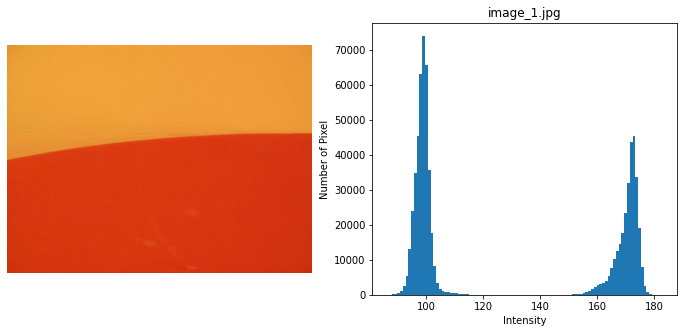

In [5]:
my_cv = show_images('./test_images')
images_ori, names = my_cv.images_and_names['images'], my_cv.images_and_names['names']
my_cv.show_images_and_hist(images_ori, figsize=(12,5))

## ข้อที่ 1 Maximum normal line method <a name="second"></a>

In [6]:
gray_image = cv2.cvtColor(images_ori[0], cv2.COLOR_RGB2GRAY)

In [7]:
def count_intensity(gray_image):
    gray_image = np.concatenate((gray_image.flatten(), np.arange(0, 256))) # for จะได้มีค่าทุก pixel
    unique, counts = np.unique(gray_image, return_counts=True)
    return unique, counts

intensity, number_of_pixel = count_intensity(gray_image)

In [8]:
def cal_slope(known_x, known_y):
    # y-y1 = m(x-x1)
    slope = (known_y[0]-known_y[1]) / (known_x[0]-known_x[1])
    return slope

def slopes_and_idx(intensity, number_of_pixel, window_size=1, step=1):
    # intensity -> x_axis
    # number_of_pixel -> y_axis
    slopes_and_idx = []
    intensity = np.concatenate((intensity, np.zeros((window_size)))) # for project out of index
    number_of_pixel = np.concatenate((number_of_pixel, np.zeros((window_size)))) # for project out of index

    for idx in range(0, 256, step):
        if intensity[idx] == 0 and number_of_pixel[idx] ==0: # for break the loop when out of range intensity and number_of_pixel
            break 
        slope = cal_slope(known_x=[intensity[idx], intensity[idx+window_size]], known_y=[number_of_pixel[idx], number_of_pixel[idx+window_size]])
        slopes_and_idx.append((slope, idx)) 
    return slopes_and_idx

slopes_and_idx = slopes_and_idx(intensity, number_of_pixel)

In [9]:
# filter ค่า slope น้อยๆอก (slope น้อยๆ เกิดขึ้นจากการใส่ 1 ทุกๆ intensity)
slope_minimum = 20
filtered_slope = [i for i in slopes_and_idx if abs(i[0]) >= slope_minimum] 

In [10]:
def find_local_max(filtered_slope):
    local_max = []
    prev_slope = filtered_slope[0][0]
    for cur_slope in filtered_slope:
        if prev_slope > 0 and cur_slope[0] < 0:
            local_max.append(cur_slope[1])
        prev_slope = cur_slope[0]   
    return local_max

In [11]:
local_max = find_local_max(filtered_slope)
local_max

[99, 173]

In [12]:
local_max_x, local_max_y = local_max, number_of_pixel[local_max]

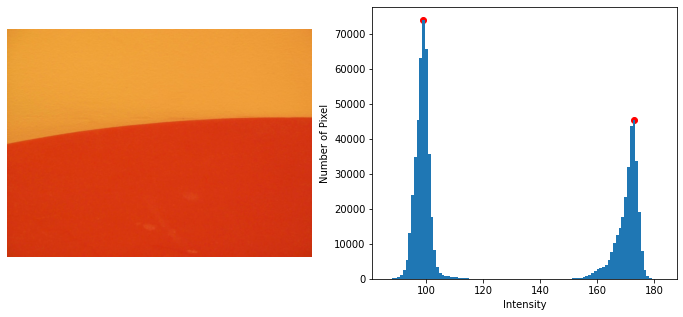

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(images_ori[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixel')
plt.hist(gray_image.flatten(), 100)
plt.scatter(local_max_x[0], local_max_y[0], color='r')
plt.scatter(local_max_x[1], local_max_y[1], color='r')
plt.show()

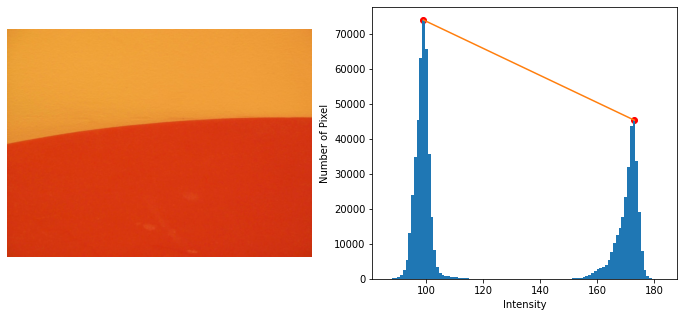

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(images_ori[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixel')
plt.hist(gray_image.flatten(), 100)
plt.scatter(local_max_x[0], local_max_y[0], color='r')
plt.scatter(local_max_x[1], local_max_y[1], color='r')
plt.plot(local_max_x, local_max_y)
plt.show()

calculate the distance from point to line (perpendicular)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/baff35b2a747a59d5a113dcabea8fda7d2c09288"/>

In [15]:
def dist_point_to_line(local_max_x, local_max_y, new_x, new_y):
    slope, c = np.polyfit(local_max_x, local_max_y, deg=1)
    a = slope
    b = -1
    dist = abs(a*new_x + b*new_y + c) / np.sqrt(a**2 + b**2)
    return dist

# test calculated by hand (0,3),(3,15) and new_x=2, new_x=3 -> 1.94
dist_point_to_line([0,3], [3,15], 2, 3)

1.9402850002906635

In [16]:
# intensity -> x_axis
# number_of_pixel -> y_axis
# find dist from point between the first local max and the second local max
start_x = local_max_x[0]
stop_x = local_max_x[-1]
distances = []
for idx in range(start_x, stop_x+1):
    distances.append(dist_point_to_line(local_max_x, local_max_y, intensity[idx], number_of_pixel[idx]))

# find max distance
max_dist_idx = np.array(distances).argmax()
print('Max distance is', max(distances))
distances[max_dist_idx]

threshold_method1 = intensity[max_dist_idx + start_x]
print('Threshold from Maximum normal line method =', threshold_method1)

Max distance is 181.19778802953795
Threshold from Maximum normal line method = 106


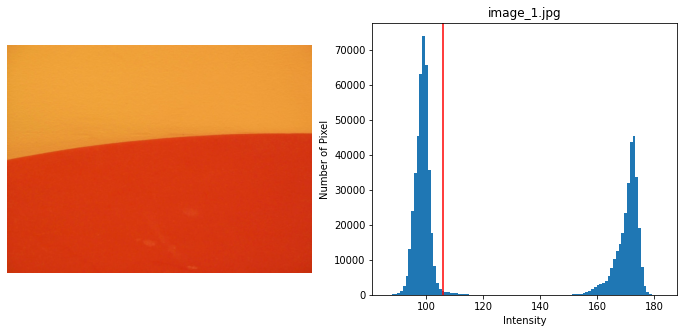

In [17]:
my_cv.show_images_and_hist(images_ori, thresholds=[threshold_method1], figsize=(12,5))

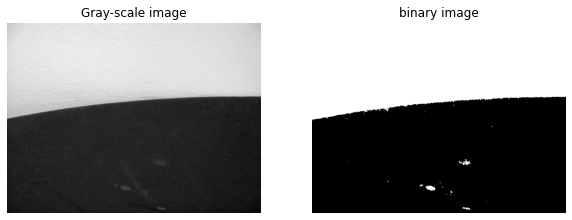

In [18]:
gray_image = cv2.cvtColor(images_ori[0], cv2.COLOR_RGB2GRAY)
binary_image_method1 = my_cv.gray_to_binary(gray_images=[gray_image], thresholds=[threshold_method1])[0]
my_cv.show_compare_images([gray_image], [binary_image_method1] ,title1='Gray-scale image', title2='binary image', nrows=1)

## ข้อที่ 2 Average intensities method <a name="third"></a>

In [19]:
def average_intensities_method(image, init_th=100, diff_th=.1, w1=1, w2=1, patience=3):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 1. initial threshold
    th = init_th
    prev_th = 0
    count = 1
    print('init th: ', th, '\n')
    for p, i in enumerate(range(patience)): 
        while abs(th - prev_th) > diff_th:
            print('iteration: ', count)
            prev_th = th

            # 2. Group 1: I(x,y) >= th => Object. Find avg intensity G1
            G1 = gray_image.copy()[gray_image.copy() >= th] # Object
            G1_mean = G1.mean()
            print('G1_mean: ', G1_mean)

            # 3. Groip 2: I(x,y) < th => Background. Find avg intensity G2
            G2 = gray_image.copy()[gray_image.copy() < th] # Background
            G2_mean = G2.mean()
            print('G2_mean: ', G2_mean)

            # 4. Update new th by weighted averaging
            th = (w1*G1_mean + w2*G2_mean) / (w1+w2)
            print('new_th: ', th, '\n')
            count += 1 
        prev_th = 0 # For patience
        print('patience: ', p+1)
    return th  

In [20]:
threshold_method2 = average_intensities_method(images_ori[0])

init th:  100 

iteration:  1
G1_mean:  148.52131578163215
G2_mean:  97.15104870809132
new_th:  122.83618224486173 

iteration:  2
G1_mean:  170.40267835288674
G2_mean:  98.5528110974302
new_th:  134.47774472515846 

iteration:  3
G1_mean:  170.47258438287153
G2_mean:  98.58902869894006
new_th:  134.5308065409058 

patience:  1
iteration:  4
G1_mean:  170.47258438287153
G2_mean:  98.58902869894006
new_th:  134.5308065409058 

patience:  2
iteration:  5
G1_mean:  170.47258438287153
G2_mean:  98.58902869894006
new_th:  134.5308065409058 

patience:  3


The adjust threshod is  135


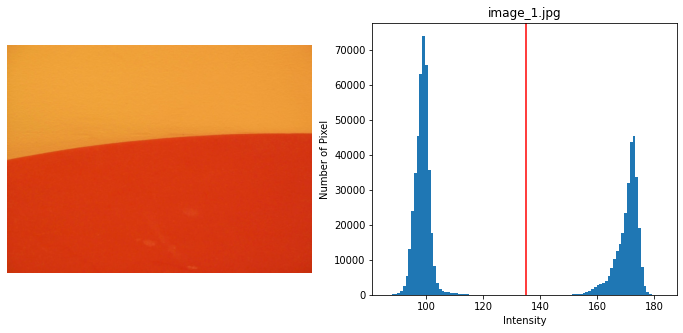

In [21]:
threshold_method2 = round(threshold_method2) # round number
print('The adjust threshod is ', threshold_method2)
my_cv.show_images_and_hist(images_ori, thresholds=[threshold_method2], figsize=(12,5))

Compare Gray-scale image and Binary image which threshold is calculated by Average intensities method

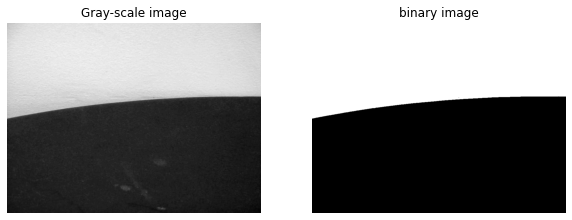

In [22]:
gray_image = cv2.cvtColor(images_ori[0], cv2.COLOR_RGB2GRAY)
binary_image_method2 = my_cv.gray_to_binary(gray_images=[gray_image], thresholds=[threshold_method2])[0]
my_cv.show_compare_images([gray_image], [binary_image_method2] ,title1='Gray-scale image', title2='binary image', nrows=1)

## Discussion <a name='forth'></a>

จากรูปตัวอย่างที่ได้ พบว่าค่า threshold ที่ได้จากทั้งสองวิธี คือ
* Maximum normal line method -> threshold = 106
* Average intensities method -> threshold = 135

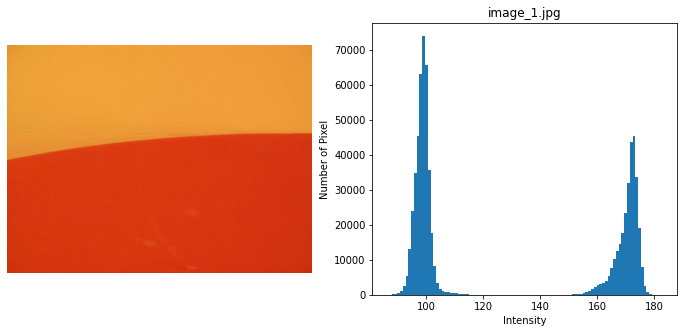

In [23]:
my_cv.show_images_and_hist(images_ori, figsize=(12,5))

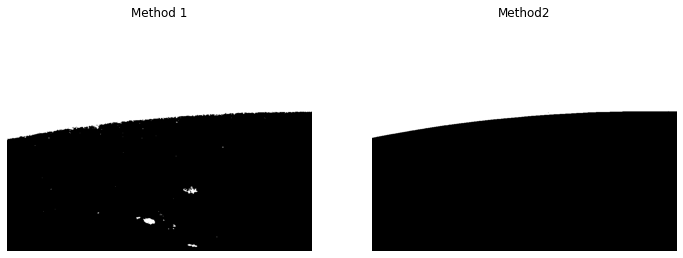

In [24]:
my_cv.show_compare_images([binary_image_method1], [binary_image_method2], title1='Method 1', title2='Method2', nrows=1, figsize=(12,5))

จากรูป พอดูด้วยสายตาแล้วพบว่า รูปภาพที่ได้จาก Average intensities method ดูดีกว่า Maximum normal line method เนื่องจากไม่มีส่วนที่เป็น noise มากเท่า